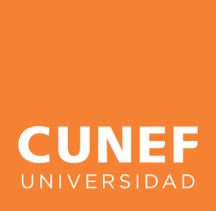
#  <font color=orange> Notebook: Clasificación Con Redes Neuronales Convolucionales</font>
## Máster de Ciencia de Datos
### Modelos de Inteligencia Artificial


___________________________________________________________________________________________
__Resumen__
En este notebook se desarrolla una clasificación de pinguinos.
El proceso de análisis sigue los siguientes pasos:
<ol>
<li>Preparación de Datos</li>
<li>Construcción de la Red Neuronal</li>
<li>Medición de la Efectividad del Módulo. Función de Coste o Pérdida</li>
<li>Mejora del Modelo. Red neuronal con regularización</li>
</ol>
___________________________________________________________________________________________

In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import random
%matplotlib inline
from sklearn.preprocessing import LabelEncoder

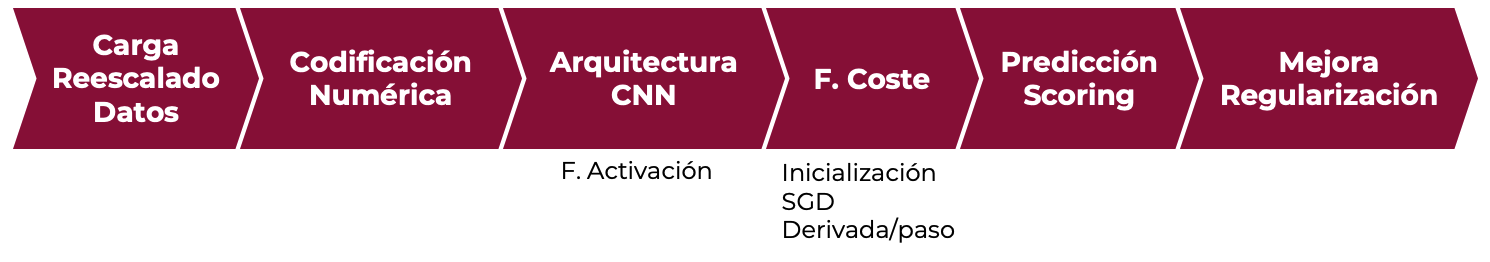

Primero prepararemos los datos para el entrenamiento, después construiremos y entrenaremos una red neuronal básica, utilizando los _modules_ y otras estructuras que proporciona Pytorch para facilitar el desarrollo y entrenamiento. Por último haremos varias pruebas y ejercicios para ver el comportamimento de nuestra red.

# 1. Preparación de los datos

Para preparar los datos seguimos los mismos pasos que para el entrenamiento de cualquier otro modelo: carga, separación, reescalado. Podemos hacerlo con las librerías que prefiramos.

## a. Carga y reescalado

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Cargamos los datos en <i>arrays pandas</i>. Se muestra el número de elementos del array resultante. El fichero contiene 334 filas y 8 columnas. Se cargará el array X_pen con las columnas con la isla, sexo, masa corporal, anchura y longitud del pico y longitud del ala. En el array Y_pen se cargan los nombres de las especies. __Ravel()__ presenta los valores transpuestos (<i>flattened</i>) de las especies

In [49]:
pen_data = pd.read_csv('penguins.csv')
pen_data

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


In [3]:
pen_data = pd.read_csv('penguins.csv')
pen_data = pen_data.dropna()
pen_data.reset_index(inplace= True)

In [4]:
le = LabelEncoder()
sex_le = le.fit_transform(pen_data['sex'])
ile_le = le.fit_transform(pen_data['island'])

In [5]:
# To add it to original dataframe, we need to convert it to data frame 

sex_le_df = pd.DataFrame(sex_le, columns=["LabelEncoder_sex"])
ile_le_df = pd.DataFrame(ile_le, columns=["LabelEncoder_ile"])
pen_data_encoded = pd.concat([pen_data, sex_le_df, ile_le_df], axis=1)
pen_data_encoded.drop(['index', 'island', 'sex'], axis = 1, inplace= True)
pen_data_encoded


,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year,LabelEncoder_sex,LabelEncoder_ile
0,Adelie,39.1,18.7,181.0,3750.0,2007,1,2
1,Adelie,39.5,17.4,186.0,3800.0,2007,0,2
2,Adelie,40.3,18.0,195.0,3250.0,2007,0,2
3,Adelie,36.7,19.3,193.0,3450.0,2007,0,2
4,Adelie,39.3,20.6,190.0,3650.0,2007,1,2
...,...,...,...,...,...,...,...,...
328,Chinstrap,55.8,19.8,207.0,4000.0,2009,1,1
329,Chinstrap,43.5,18.1,202.0,3400.0,2009,0,1
330,Chinstrap,49.6,18.2,193.0,3775.0,2009,1,1
331,Chinstrap,50.8,19.0,210.0,4100.0,2009,1,1


In [6]:
X_pen = pen_data_encoded[[ 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'LabelEncoder_sex', 'LabelEncoder_ile']].values  # La X mayuscula es una matriz
y_pen = pen_data[['species']].values  # La y minúscula es un vector
print(X_pen.shape)

y_pen = pen_data[['species']].values.ravel()
print(y_pen.shape)

(333, 6)
(333,)


Particionamos el dataset en el subconjunto de entrenamiento (50%) y el de validación (50%) 

In [7]:
X_pen_train, X_pen_test, y_pen_train, y_pen_test = train_test_split(X_pen, y_pen, test_size=50, random_state=123,
                                                                        shuffle=True, stratify=y_pen) 
# Shuffle: Cada vez que hace una partición hace que no coincidan
# Stratify: En la función de test y train va a tener la misma proporción de variables que el df original (PE. 25% , 50%  y 25% de otra)
print(X_pen_train.shape)
print(X_pen_test.shape)

(283, 6)
(50, 6)


Empleamos la función <i>StandardSCaler()</i> para estandarizar los datos mediante la transformación de la tipificación o estandarización. La nueva variable estandarizada será un transformación de la anterior restando la media y dividiendo por la desviación estándar, es decir, se distribuirá como una normal de media 0 y varianza 1 [N(0,1)].

In [8]:
pen_scaler = StandardScaler() # Creamos el transformador
pen_scaler.fit(X=X_pen_train) # Ajustamos los parametros

StandardScaler()

Reescalamos los datos de las particiones de entrenamiento y de validación

In [9]:
X_pen_train_sc = pen_scaler.transform(X_pen_train)
X_pen_test_sc = pen_scaler.transform(X_pen_test)

In [10]:
print("Entrenamiento (media no std): {}".format(np.mean(X_pen_train, axis=0)))
print("Entrenamiento (media std): {}".format(np.mean(X_pen_train_sc, axis=0)))
print("Entrenamiento: (desv. tipica std) {}".format(np.std(X_pen_train_sc, axis=0)))

Entrenamiento (media no std): [4.40307420e+01 1.71703180e+01 2.00816254e+02 4.21042403e+03
 5.05300353e-01 6.57243816e-01]
Entrenamiento (media std): [ 1.38091344e-16 -5.60152631e-15  8.00302110e-17 -1.90660208e-16
  1.48291273e-16 -8.19917357e-17]
Entrenamiento: (desv. tipica std) [1. 1. 1. 1. 1. 1.]


In [11]:
print("Validación: (media no std) {}".format(np.mean(X_pen_test, axis=0)))
print("Validación: (media std):{}".format(np.mean(X_pen_test_sc, axis=0)))
print("Validación %: (desv. tipica std) {}".format(np.std(X_pen_test_sc, axis=0)))

Validación: (media no std) [4.3778e+01 1.7134e+01 2.0182e+02 4.1880e+03 5.0000e-01 6.2000e-01]
Validación: (media std):[-0.04575134 -0.01840126  0.07083273 -0.02796714 -0.0106013  -0.05189663]
Validación %: (desv. tipica std) [0.91938349 0.97463193 0.91180175 1.01786426 1.00005619 0.96096133]


## b. Codificador numérico de etiquetas alfanuméricas
Para poder tratar correctamente las distintas categorías de nuestro set de datos en la red neuronal debemos codificar las etiquetas como valores numéricos, en lugar de alfanuméricos. El transformador LabelEncoder de Scikit-Learn tiene esta funcionalidad

In [12]:
lae = LabelEncoder() # creamos el transformador
lae.fit(y_pen_train) # lo entrenamos con las etiquetas del subconjunto de entrenamiento 
print(lae.classes_)
print(lae.transform(lae.classes_))

['Adelie' 'Chinstrap' 'Gentoo']
[0 1 2]


Con el transformador entrenado podemos transformar las etiquetas de las particiones de entrenamiento y de validación

In [13]:
y_pen_train_la = lae.transform(y_pen_train)
y_pen_test_la = lae.transform(y_pen_test)
y_pen_train_la

array([1, 0, 0, 1, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 1, 1, 2, 1, 0, 1,
       0, 0, 0, 2, 0, 2, 2, 0, 1, 1, 2, 2, 2, 1, 0, 1, 0, 0, 2, 1, 1, 0,
       0, 0, 0, 1, 1, 2, 0, 0, 2, 2, 0, 2, 0, 2, 0, 1, 2, 1, 0, 2, 0, 2,
       2, 0, 2, 0, 1, 1, 0, 2, 1, 2, 0, 1, 0, 0, 2, 2, 0, 1, 1, 0, 0, 0,
       2, 1, 2, 2, 0, 2, 2, 1, 0, 0, 2, 1, 2, 0, 0, 2, 2, 0, 0, 0, 2, 1,
       2, 2, 2, 2, 2, 1, 1, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2, 1, 0, 0,
       1, 2, 0, 2, 0, 0, 1, 1, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 2, 0, 0,
       0, 0, 2, 0, 1, 1, 2, 0, 2, 1, 2, 2, 1, 2, 2, 0, 0, 0, 1, 2, 0, 0,
       2, 0, 0, 0, 0, 1, 1, 1, 1, 2, 0, 0, 2, 0, 0, 1, 1, 2, 1, 2, 1, 2,
       2, 0, 0, 2, 0, 0, 0, 0, 0, 1, 2, 1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 2,
       2, 2, 2, 0, 2, 0, 2, 1, 2, 0, 2, 0, 0, 1, 0, 2, 2, 0, 1, 0, 2, 1,
       2, 0, 0, 0, 2, 2, 2, 0, 1, 2, 0, 0, 0, 2, 1, 0, 0, 2, 0, 2, 2, 2,
       2, 2, 1, 2, 0, 0, 2, 2, 0, 0, 1, 0, 2, 1, 0, 1, 2, 0, 2])

Por medio de la funcion <i>inverse_transform()</i> de la librería scikit learn podemos devolver a las etiquetas a su anterior a la codificación

In [14]:
lae.inverse_transform([2])
print(lae.inverse_transform(y_pen_test_la))

['Gentoo' 'Chinstrap' 'Gentoo' 'Chinstrap' 'Adelie' 'Gentoo' 'Chinstrap'
 'Chinstrap' 'Adelie' 'Gentoo' 'Adelie' 'Adelie' 'Gentoo' 'Gentoo'
 'Adelie' 'Gentoo' 'Adelie' 'Adelie' 'Gentoo' 'Gentoo' 'Adelie' 'Adelie'
 'Gentoo' 'Chinstrap' 'Gentoo' 'Adelie' 'Adelie' 'Adelie' 'Adelie'
 'Adelie' 'Chinstrap' 'Chinstrap' 'Adelie' 'Gentoo' 'Chinstrap' 'Adelie'
 'Adelie' 'Gentoo' 'Gentoo' 'Adelie' 'Gentoo' 'Adelie' 'Adelie' 'Gentoo'
 'Chinstrap' 'Adelie' 'Chinstrap' 'Gentoo' 'Adelie' 'Gentoo']


## c. Transformación de los datos a tensores

Podemos transformar los arrays de la librería <i>Numpy</i> a tensores de Pytorch. utilizando la función torch.tensor(np_array). 

Para poder visualizar lo que está ocurriendo, empezaremos por coger solo 2 de las variables

El argumento __requires_grad__ guarda el gradiente (las derivadas de la función). Este argumento debe emplearse con medida, ya que requiere que todas las derivadas se almacenan en el _device_.

In [15]:
tX_train = torch.tensor(X_pen_train_sc, requires_grad=False, dtype=torch.float)[:, 0:2] # tomamos sólo 2 variables (los dos primeros)
tX_test = torch.tensor(X_pen_test_sc, requires_grad=False, dtype=torch.float)[:, 0:2] # tomamos sólo 2 variables
ty_train = torch.tensor(y_pen_train_la, requires_grad=False, dtype=torch.long)  
ty_test = torch.tensor(y_pen_test_la, requires_grad=False, dtype=torch.long)  

In [16]:
print(tX_train.shape)
print(tX_test.shape)
print(ty_train.shape)
print(ty_test.shape)

torch.Size([283, 2])
torch.Size([50, 2])
torch.Size([283])
torch.Size([50])


# 2. Construcción de la red neuronal

Para abordar el problema de clasificación diseñamos una red neuronal obtenga la probabilidad de pertenencia a cada una de las tres posibles especies dadas las variables. La capa de entrada tendrá entonces dos unidades o neuronas, y la capa de salida tendrá tres. Como punto de partida vamos a implementar una red sencilla con sólo una capa intermedia de 80 unidades. 

## a. Arquitectura - "Propagación hacia adelante" (*Forward Pass*)
La arquitectura de la red será la siguiente:

Como función de activación de la capa 2 (la de salida) utilizaremos la función Softmax(), ya que queremos obtener probabilidades como salida de nuestra red y esta función reescala los inputs de forma que los outputs estén entre 0 y 1, y además sumen 1:
- $0 \le \mathrm{Softmax}(x)_i = \frac{e^{x_i}}{\sum_j e^{x_j}} \le 1 $

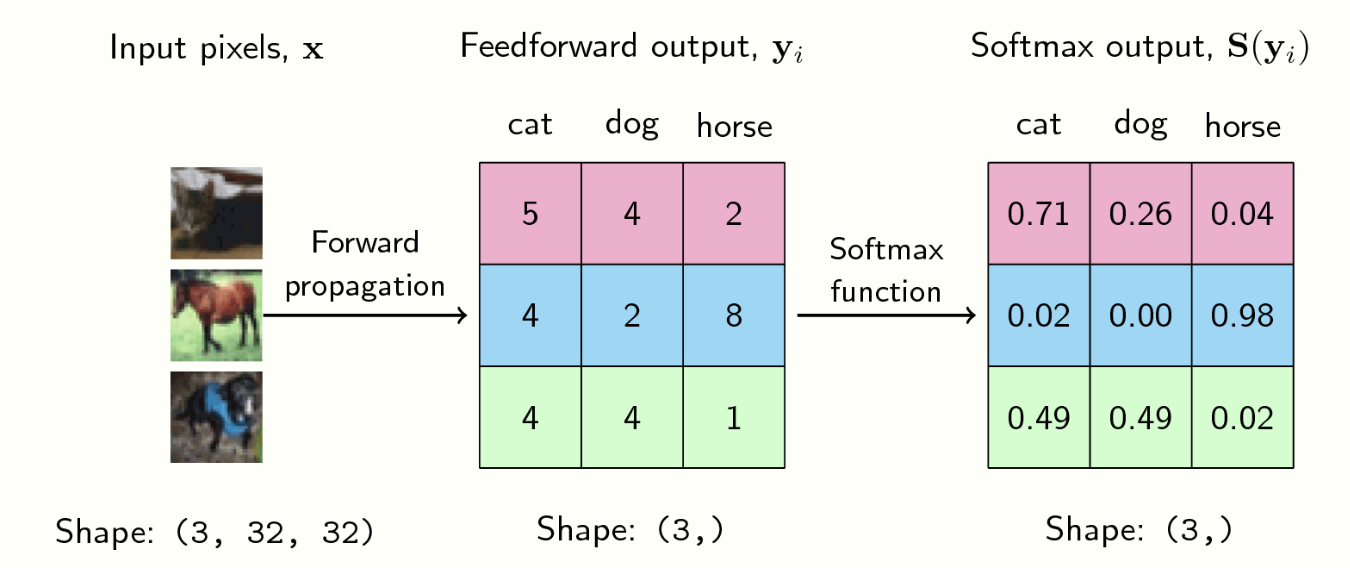

## b. Implantación de la Propagación hacia Adelante (*Forward pass*)

Aunque podrían construirse redes neuronales simplemente con productos de matrices y algunas funciones, el código se complica rápidamente cuando aumentamos el tamaño y la complejidad de la red neuronal. 


Para facilitar la implantación de redes neuronales profundas, Pytorch emplea la estructura _module_. Un _module_ (módulo) es una clase (objeto) que incorpora el método __forward()__, que representa la _propagación hacia adelante_ de dicho módulo. Un módulo puede ser tan sencillo como una sola capa, o contener una red neuronal entera (en general, un módulo a su vez puede contener módulos). 

Para redes sencillas, el módulo mas útil suele ser *nn.Linear*, que proporciona una capa lineal con su matriz de pesos $\mathbf{W}$ y su vector de sesgos (*bias*) $\mathbf{b}$.

Aplica una transformación lineal totalmente conectada a los datos de entrada: $y = xA^{T} + b$

$$
(y_1, y_2, y_3, y_4, y_5) = (x_1, x_2) 
\left(\begin{array}{cc} 
A_{11} & A_{12} & A_{13} & A_{14} & A_{15}\\
A_{21} & A_{22} & A_{23} & A_{24} & A_{25}\\
\end{array}\right)
+ (b_1, b_2, b_3, b_4, b_5)
$$ 




Parámetros:

 <b>in_features</b>: número de unidades de entrada <br>
 <b>out_features</b>: número de unidades de salida <br>
 <b>bias</b>: si se establece como False, la capa no añadirá un sesgo aditivo. Predeterminado: Verdadero

In [17]:
linear_1 = torch.nn.Linear(2,5) # una capa lineal de 2 unidades de entrada y 5 unidades de salida
                                # nn es red neuronal lineal 
linear_1

Linear(in_features=2, out_features=5, bias=True)

In [18]:
tX_train.shape[0:2]

torch.Size([283, 2])

Para ejecutar la propagación hacia adelante de un módulo:

In [19]:
linear_1(tX_train[0:2,:])# aplicamos la transformación lineal a las dos primeras variables. Fully Conected. Multiplicación de los pesos por la entrada.

tensor([[ 0.0090,  0.5065,  0.9715, -0.4379, -0.2734],
        [-0.3737, -0.0295, -0.2812, -1.7941,  0.0624]],
       grad_fn=<AddmmBackward0>)

In [20]:
tX_train.shape[1]

2

Podemos encadenar módulos utilizando _nn.Sequential_ (que, a su vez, es un módulo). Los módulos proporcionados al definir un _nn.Sequential_ se aplican en el orden indicado, de forma que la función _forward_ completa es el resultado de hacer el _forward_ del primer módulo con los datos como input, hacer el _forward_ del segundo módulo usando el output del primero como input, etc...

Siguiendo nuestra arquitectura, podemos definir nuestra red de la siguiente manera:

In [21]:
nn1 = torch.nn.Sequential(
    torch.nn.Linear(tX_train.shape[1], 80), # capa lineal con 2 entradas y 80 salidas
    torch.nn.ReLU(),  # activación ReLU
    torch.nn.Linear(80, len(lae.classes_)), # capa lineal con 80 entradas y 3 salidas. 
    # Recordemos que lae codifica numéricamente las etiquetas con números
    # lae.classes_ = array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)
    torch.nn.LogSoftmax(dim=1) # El output es el log de la probabilidad de pertenencia a cada categoría (class)
)

Nota: en lugar del *Softmax* hemos aplicado la función *LogSoftmax* que es mas estable (es el logaritmo de la función *Softmax*). Podemos volver a los valores originales de las probabilidades con exp(nn1(x)). 
La función de activación Softmax permite convertir la salida de una capa lineal en una distribución de probabilidad categórica.

Podemos ver los parámetros de nuestra red usando el método named_parameters()

In [22]:
for name, param in nn1.named_parameters():
    print(name, param.shape) # Nota: los módulos ReLU y LogSoftmax no tienen parámetros

0.weight torch.Size([80, 2])
0.bias torch.Size([80])
2.weight torch.Size([3, 80])
2.bias torch.Size([3])


Devuelve la matriz de pesos de 80 x 2, el vector de sesgo de 80 x 1 para las entradas; la matriz de pesos de 3 x 80 y suy vector de sesgos de 3 x 1 para la salida

Para comprobar que efectivamente nos devuelve tres columnas con probabilidades, introducimos un bloque de filas de nuestros datos (un 'batch') en el *forward pass*:

In [23]:
print(torch.exp(nn1(tX_train[0:5,:]))) # introducimos las primeras 5 filas de nuestros datos
print(ty_train[0:5]) # las etiquetas correspondientes
lae.inverse_transform(ty_train[0:5])

tensor([[0.3457, 0.3333, 0.3209],
        [0.3701, 0.3682, 0.2617],
        [0.3793, 0.3352, 0.2855],
        [0.3241, 0.3609, 0.3150],
        [0.4595, 0.2585, 0.2820]], grad_fn=<ExpBackward0>)
tensor([1, 0, 0, 1, 2])


array(['Chinstrap', 'Adelie', 'Adelie', 'Chinstrap', 'Gentoo'],
      dtype=object)

El output es la probabilidad de ser cada una de las especies en cada uno de los 5 ejemplos

In [24]:
print(lae.classes_)

['Adelie' 'Chinstrap' 'Gentoo']


## 3. Medición de la Efectividad del Módulo. Función de Coste o Pérdida

Vemos que aunque técnicamente funciona y nos devuelve probabilidades, estas no discriminan (esperaríamos que la probabilidad mas alta se dé en alguna etiqueta. Para validar el modelo definimos una función de pérdida, que devuelve, dadas unas etiquetas reales y las probabilidades predichas por nuestro modelo, un número que determina la bondad de nuestras predicciones (en general, a mayor coste o pérdida, peor es el modelo).

Para problemas de clasificación suele usarse la función de pérdida <b>Negative Log likelihood Loss (NLLLoss)</b>. La NLLLoss para cada fila se calcula como -log() de la probabilidad asignada por el modelo a la etiqueta real correspondiente a dicha fila, y el coste de un minilote es la media de la pérdida de cada fila. 

Como habíamos definido la red nn1 con LogSoftMax, sólo debemos invocarla con un signo negativo (-nn1)

https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss

Por ejemplo:

In [25]:
# Cálculo a Manija de la -log

print(tX_train[0:2,:])
n_logs_p = -nn1(tX_train[0:2,:]) # -log(p)
print(n_logs_p)

labels_reales = ty_train[0:2] # las labels reales, las y reales
print(labels_reales) # Printea los log
print("Coste 1: ", n_logs_p[0,labels_reales[0]].item()) # Printea los Labels reales
print("Coste 2: ", n_logs_p[1,labels_reales[1]].item()) # Printea los Labels reales
print("Total: ", (n_logs_p[0,labels_reales[0]].item() + n_logs_p[1,labels_reales[1]].item())/2) # Nos da el error, la entropía en media

tensor([[ 1.0262,  0.7244],
        [-1.2908,  0.7244]])
tensor([[1.0621, 1.0986, 1.1365],
        [0.9941, 0.9991, 1.3404]], grad_fn=<NegBackward0>)
tensor([1, 0])
Coste 1:  1.0986418724060059
Coste 2:  0.9940890073776245
Total:  1.0463654398918152


In [26]:
print(labels_reales[0], labels_reales[1])

tensor(1) tensor(0)


In [27]:
-nn1(tX_train[0:2,:])

tensor([[1.0621, 1.0986, 1.1365],
        [0.9941, 0.9991, 1.3404]], grad_fn=<NegBackward0>)

Podemos utilizar la función de NLLLoss predefinida de Pytorch. Comprobamos que el coste total es el mismo resultado que aplicando el -log de la pérdida

In [28]:
torch.nn.functional.nll_loss(nn1(tX_train[0:2,:]), ty_train[0:2]) # El error total de aproximación del modelo.

tensor(1.0464, grad_fn=<NllLossBackward0>)

## a. Inicialización de parámetros

Los valores iniciales de nuestros parámetros serán nuestro punto de partida en el entrenamiento. Al crear los parámetros de los módulos, Pytorch por defecto los inicializa a valores aleatorios con unas propiedades específicas.
Aunque pueda parecer un aspecto secundario, la forma de inicializar nuestros pesos y sesgo (*bias*) tiene una influencia directa sobre la calidad final de nuestra red y puede marcar la diferencia entre una red que <b>aprende</b> y otra que no.

Hay diversas técnicas para inicializar los pesos, y la elección depende del tipo de red, del tamaño, de las funciones de activación... Para nuestra red, sobreescribiremos los valores proporcionados por Pytorch e inicializaremos cada peso con un número aleatorio entre 0 y 1 (al ser una red pequeña, esto en principio no nos dará problemas).

Inicializamos las semillas de generación de números aleatorios

In [29]:
def do_seeds(sn):
    np.random.seed(sn)
    torch.manual_seed(sn)
    random.seed(sn)
do_seeds(0) 

In [30]:
do_seeds(12)
for param in nn1.parameters():
    torch.nn.init.uniform_(param, 0, 1) # Inicialización de los parámetros, en este caso todos por igual.

# Rellena el tensor de entrada con valores extraídos de la distribución uniforme U(a, b)

Nota: en 'torch.init' hay una serie de inicializaciones utilizadas habitualmente.

## b. Entrenamiento: _Empleo de Optimizadores de la Función de Pérdida_

Una vez definida la propagación hacia adelante y la función de pérdida, e inicializados los parámetros, podemos iniciar el entrenamiento. El entrenamiento consiste en modificar iterativamente los parámetros de manera que nuestra pérdida vaya disminuyendo. Para poder disminuir la pérdida de forma consistente tenemos que saber en qué dirección modificar los parámetros; esta información nos lo dan las __derivadas__. 

La forma mas sencilla de hacerlo consiste en calcular en cada iteración la derivada de la pérdida con respecto a cada parámetro, y modificar cada parámetro restándole su derivada multiplicada por un ratio (la tasa de aprendizaje o *learning rate*). Este algoritmo de optimización se denomina SGD (__Stochastic Gradient Descent__) y a pesar de su sencillez da muy buenos resultados (la mayoría de los algoritmos mas sofisticados para el entrenamiento de redes neuronales se basan en éste). Recordemos que la diferencia entre el Descenso del Gradiente estándar y el estocástico es que el primero debe realizar la optimización de la pérdida con toda la muestra, mientras que el segundo toma minilotes (pequeñas muestras) aleatoriamente y calcula la pérdida. Por tanto, el primero es preciso pero lento, y el segundo es razonablemente preciso y mucho más rápido.

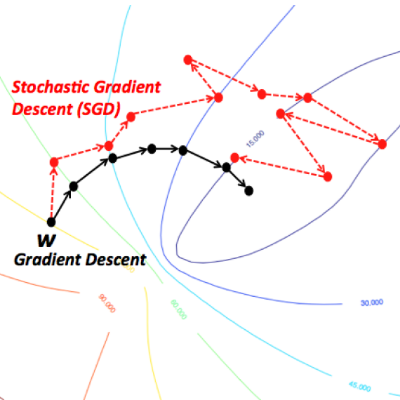

In [31]:
opt = torch.optim.SGD(nn1.parameters(), lr=0.02)  # empleamos el optimizador SGD en la red neuronal nn1 
                                                  # con una tasa de aprendizaje de 0.02

Comenzamos el entrenamiento avanzando a medida que aumentan los _step()_ en el espacio de parámetros de nuestra red neuronal en la dirección del gradiente para disminuir la pérdida en cada paso:

In [32]:
for i in range(10000):  
    pred_y = nn1(tX_train) # calculamos nuestras predicciones con los parámetros actuales
    loss = torch.nn.functional.nll_loss(pred_y, ty_train) # calculamos el coste o entropía de los resultados 
    
    if i%1000 == 0:
        print("Época: {}, Pérdida: {:.4f}".format(i, loss.item()))
        loss.backward() # propagamos las derivadas de la 'loss' con respecto a nuestros parámetros
        opt.step() # ejecutamos un paso de nuestro optimizador, dirección del gradiente.
        opt.zero_grad() # reseteamos los valores acumulados de las derivadas para que no las acumule

Época: 0, Pérdida: 1.7460
Época: 1000, Pérdida: 1.5621
Época: 2000, Pérdida: 1.3898
Época: 3000, Pérdida: 1.2310
Época: 4000, Pérdida: 1.0909
Época: 5000, Pérdida: 0.9750
Época: 6000, Pérdida: 0.8856
Época: 7000, Pérdida: 0.8183
Época: 8000, Pérdida: 0.7658


Época: 9000, Pérdida: 0.7226


## c. Predicción y scoring

Ahora que tenemos nuestra red neuronal entrenada, podemos generar predicciones escogiendo el valor al que se haya asignado mayor probabilidad en cada fila.

Nota: una vez concluido el entrenamiento de nuestra red, sobre todo si es grande, conviene desactivar __requires_grad__ de nuestros parámetros para ahorrar memoria y tiempo de ejecución a la hora de utilizarla para hacer predicciones. 

In [33]:
for param in nn1.parameters():
    param.requires_grad = False  #eliminar requires_grad de todas y cada una de las capas

Definimos una función que devuelva estas predicciones dado un conjunto de filas.
La función toma los datos de entrada, evalúa la red y obtiene las probabilidades de salida de ser cada una
de las tres especies. Se devuelve el valor númerico de la especie que tiene mayor probabilidad (la máxima)

In [34]:
def pred_f(x, forw):
    x_t = torch.tensor(x, dtype=torch.float, requires_grad=False)
    _,y_pred = torch.max(forw(x_t), dim=1)   # Las predicciones de la red y dará el máximo
    return y_pred

In [35]:
tX_train[0:5,:]

tensor([[ 1.0262,  0.7244],
        [-1.2908,  0.7244],
        [-0.8202,  0.3190],
        [ 1.3883,  1.5857],
        [-0.4219, -1.2516]])

Con esto podemos generarnos una función de scoring para nuestra red neuronal, que calcule el número de aciertos.

In [36]:
print(pred_f(tX_train[0:5,:], nn1)) # las predicciones para las 5 primeras filas
print(ty_train[0:5]) # sus 'labels' reales
lae.inverse_transform(ty_train[0:5])

tensor([1, 1, 1, 0, 2])
tensor([1, 0, 0, 1, 2])


c:\Users\USUARIO\miniconda3\envs\practica_ml\lib\site-packages\ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


array(['Chinstrap', 'Adelie', 'Adelie', 'Chinstrap', 'Gentoo'],
      dtype=object)

Escribimos la función de *scoring* que evalúa  el porcentaje de aciertos dado un conjunto de filas con sus etiquetas.

In [37]:
def score_f(x, y, forw):
    y_label = torch.tensor(y, dtype=torch.long, requires_grad=False)   # recupera el valor histórico de y
    y_pred = pred_f(x, forw)                                           # obtiene la predicción de y
    
    # devuelve el % aciertos (cuando y coincide con y_pred)
    return torch.sum(y_pred == y_label).item() / len(y_label)                                             

In [38]:
score_f(tX_train, ty_train, nn1) 

c:\Users\USUARIO\miniconda3\envs\practica_ml\lib\site-packages\ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


0.6254416961130742

In [39]:
score_f(tX_test, ty_test, nn1)

c:\Users\USUARIO\miniconda3\envs\practica_ml\lib\site-packages\ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


0.58

Los porcentajes de acierto son muy bajos, y además muy diferentes entre el conjunto de entrenamiento y de test señalando _sobreaprendizaje_

## 4. Mejora del Modelo. Red neuronal con regularización

Empleando *nn.Sequential* generamos el *forward pass* de una red neuronal (nn2) similar a 'nn1' pero con 4 capas (en lugar de 3): 
 La arquitectura de la red es:
    1. capa de entrada lineal totalmente conectada de 2 x 200. Función de activación ReLu()
    2. capa lineal totalmente conectada de 200 x 100. Función de activación ReLu()
    3. capa lineal totalmente conectada de 100 x 3. Función de activación LogSoftMax()
    4. capa de salida 3 x 1

In [40]:
nn2 = torch.nn.Sequential(
    torch.nn.Linear(tX_train.shape[1], 200), 
    torch.nn.ReLU(), 
    torch.nn.Linear(200, 100), 
    torch.nn.ReLU(), 
    torch.nn.Linear(100, len(lae.classes_)), 
    torch.nn.LogSoftmax(dim=1) # El output es la probabilidad de pertenencia a cada categoría
)

In [41]:
# reinicializamos los parámetros
do_seeds(12)
for param in nn2.parameters():
    torch.nn.init.uniform_(param, 0, 1) 

Entrenamos la red con el optimizador SGD lr=0.02. En esta ocasión añadimos un parámetro adicional de regularización __weight_decay__=0.02.

__Weight Decay__ (caída de peso), norma L2 o _Ridge Regression_ es una técnica de regularización que agrega una pequeña penalización a la función de pérdida.
    
    
    pérdida = pérdida + parámetro de caída de peso * pendiente²
    
Mantiene los pesos pequeños y evitar la explosión del gradiente. Debido a que la norma L2 de los pesos se agrega a la pérdida, cada iteración de su red intentará optimizar / minimizar los pesos del modelo además de la pérdida. Ayuda a evitar el sobreajuste en los últimos datos de una serie; al penalizar la pendiente tiende a bajar es más conservador.


Weight Decay es un parámetro del optimizador SGD

In [42]:
len(lae.classes_)

3

In [43]:
opt2 = torch.optim.SGD(nn2.parameters(), lr=0.02, weight_decay=0.02)

In [44]:
for i in range(10000):
    opt2.zero_grad() # reseteamos los valores acumulados de las derivadas y tampoco se van acumulando.
    pred_y = nn2(tX_train) # calculamos nuestras predicciones con los parámetros actuales
    loss = torch.nn.functional.nll_loss(pred_y, ty_train) # calculamos la 'loss' con los resultados 
    if i%1000 == 0:
        print("Época: {}, Péŕdida: {:.4f}".format(i, loss.item()))
    loss.backward() # propagamos las derivadas de la 'loss' con respecto a nuestros parámetros
    opt2.step() # ejecutamos un paso de nuestro optimizador

Época: 0, Péŕdida: 42.0755


Época: 1000, Péŕdida: 0.1004
Época: 2000, Péŕdida: 0.1114
Época: 3000, Péŕdida: 0.1203
Época: 4000, Péŕdida: 0.1263
Época: 5000, Péŕdida: 0.1290
Época: 6000, Péŕdida: 0.1311
Época: 7000, Péŕdida: 0.1324
Época: 8000, Péŕdida: 0.1324
Época: 9000, Péŕdida: 0.1315


In [45]:
for param in nn2.parameters():
    param.requires_grad = False

In [46]:
score_f(tX_train, ty_train, nn2)

c:\Users\USUARIO\miniconda3\envs\practica_ml\lib\site-packages\ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


0.9611307420494699

In [47]:
score_f(tX_test, ty_test, nn2)

c:\Users\USUARIO\miniconda3\envs\practica_ml\lib\site-packages\ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


0.96

La tasa de acierto ()_scoring_) es mucho mayor y estable (la diferencia entre la tasa de error con el conjunto de entreanmiento y de test es muy reducida)